In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.load import get_patched_data, get_patched_src, subsample
from data.utils import custom_cutout
from model.metrics import psnr, ssim

## Choose Devices

In [4]:
gpu_id = 1
num_cores = 4

In [5]:
torch.cuda.set_device(gpu_id)

## Set Experiment Name

In [6]:
nb_name = 'critic_patches_resnet_pretrained'

## Load Data

In [7]:
bs = 8  # batch size
size = 256  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF')  # path to dataset
lr_dir = f'EM/training/trainsets/lr/'  # input images
hr_dir = f'EM/training/trainsets/hr/'  # target images
model_pth = data_pth/f'EM/models/critics'  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF
/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics


In [8]:
random_patch = partial(custom_cutout, min_n_holes=10, max_n_holes=20,
                       min_length=15, max_length=25, use_on_y=False)

In [9]:
tfms = [[random_patch()], [random_patch()]]

In [10]:
tfms

[[RandTransform(tfm=TfmPixel (custom_cutout), kwargs={'min_n_holes': 10, 'max_n_holes': 20, 'min_length': 15, 'max_length': 25}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=False)],
 [RandTransform(tfm=TfmPixel (custom_cutout), kwargs={'min_n_holes': 10, 'max_n_holes': 20, 'min_length': 15, 'max_length': 25}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=False)]]

In [11]:
# Create databunch
data = get_patched_data(data_pth, hr_dir, bs, tfms=tfms,
                        in_sz=size, out_sz=size)

In [12]:
# Dataset sizes
len(data.train_ds), len(data.valid_ds)

(79998, 19999)

In [13]:
# Batch size and number of batches
data.batch_size, len(data.train_dl)

(8, 9999)

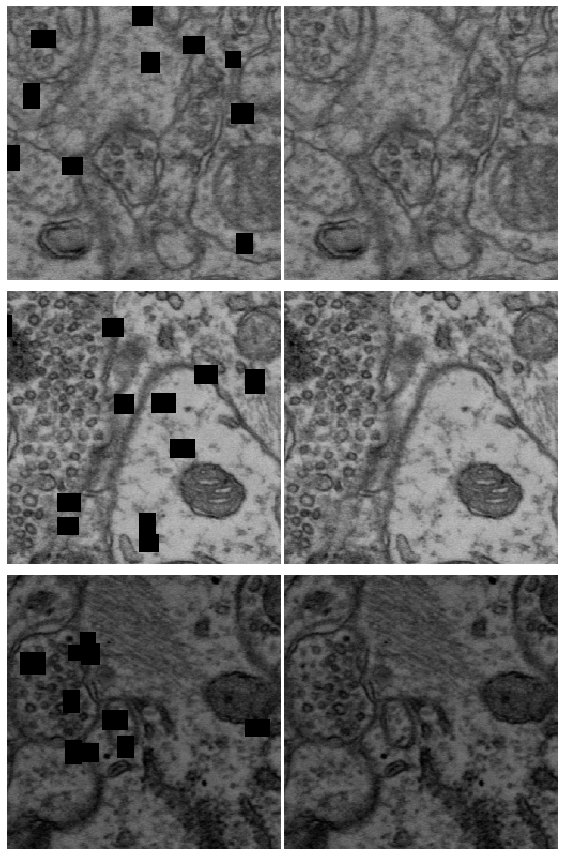

In [14]:
# Data Visualization
data.show_batch(rows=3)

## Data Subsample

In [15]:
data = subsample(data)

In [16]:
data.c

3

In [17]:
# Dataset sizes
len(data.train_dl), len(data.valid_dl)

(999, 250)

In [18]:
# Batch size and number of batches
data.batch_size

8

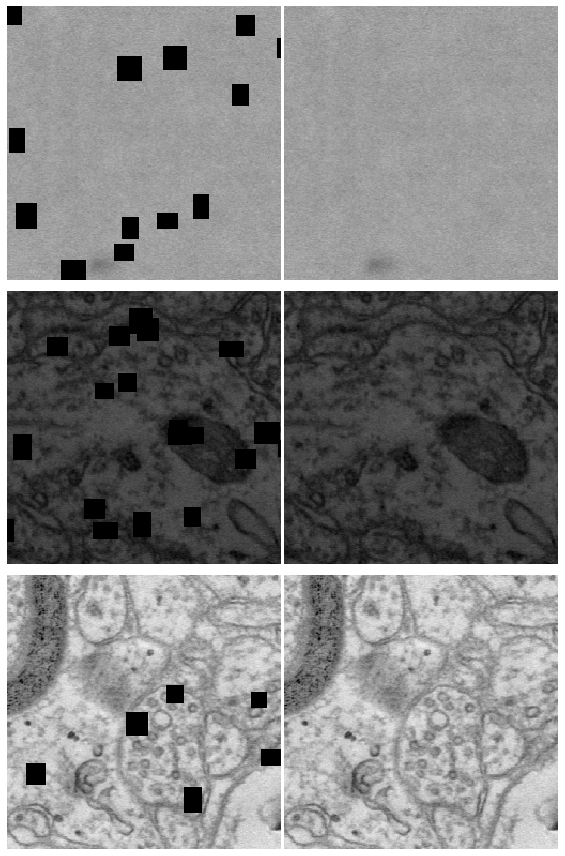

In [19]:
# Data Visualization
data.show_batch(rows=3)

# Model

## Initialization

In [20]:
arch = models.resnet34
wd = 1e-3
metrics = [F.mse_loss, psnr, ssim]
learn = unet_learner(data, arch, wd=wd, 
                         #loss_func=feat_loss,
                         loss_func=F.mse_loss,
                         metrics=metrics, 
                         #callback_fns=LossMetrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_pth)
gc.collect()

25521

In [21]:
learn.model_dir = model_pth
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/critics


## Load Model (optional)

In [22]:
# learn.model_dir = model_pth
learn = learn.load(f'{nb_name}.2c')

## Training

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


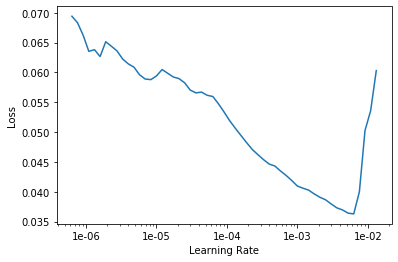

In [32]:
learn.recorder.plot()

### 1a

In [33]:
lr = 1e-4
learn.fit_one_cycle(1, max_lr=lr)
learn.save(f'{nb_name}.2a', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.006444,0.006191,0.006191,22.150911,0.958945,03:14


In [24]:
learn.validate()

[0.0055822018, tensor(0.0056), tensor(22.5521), tensor(0.9367)]

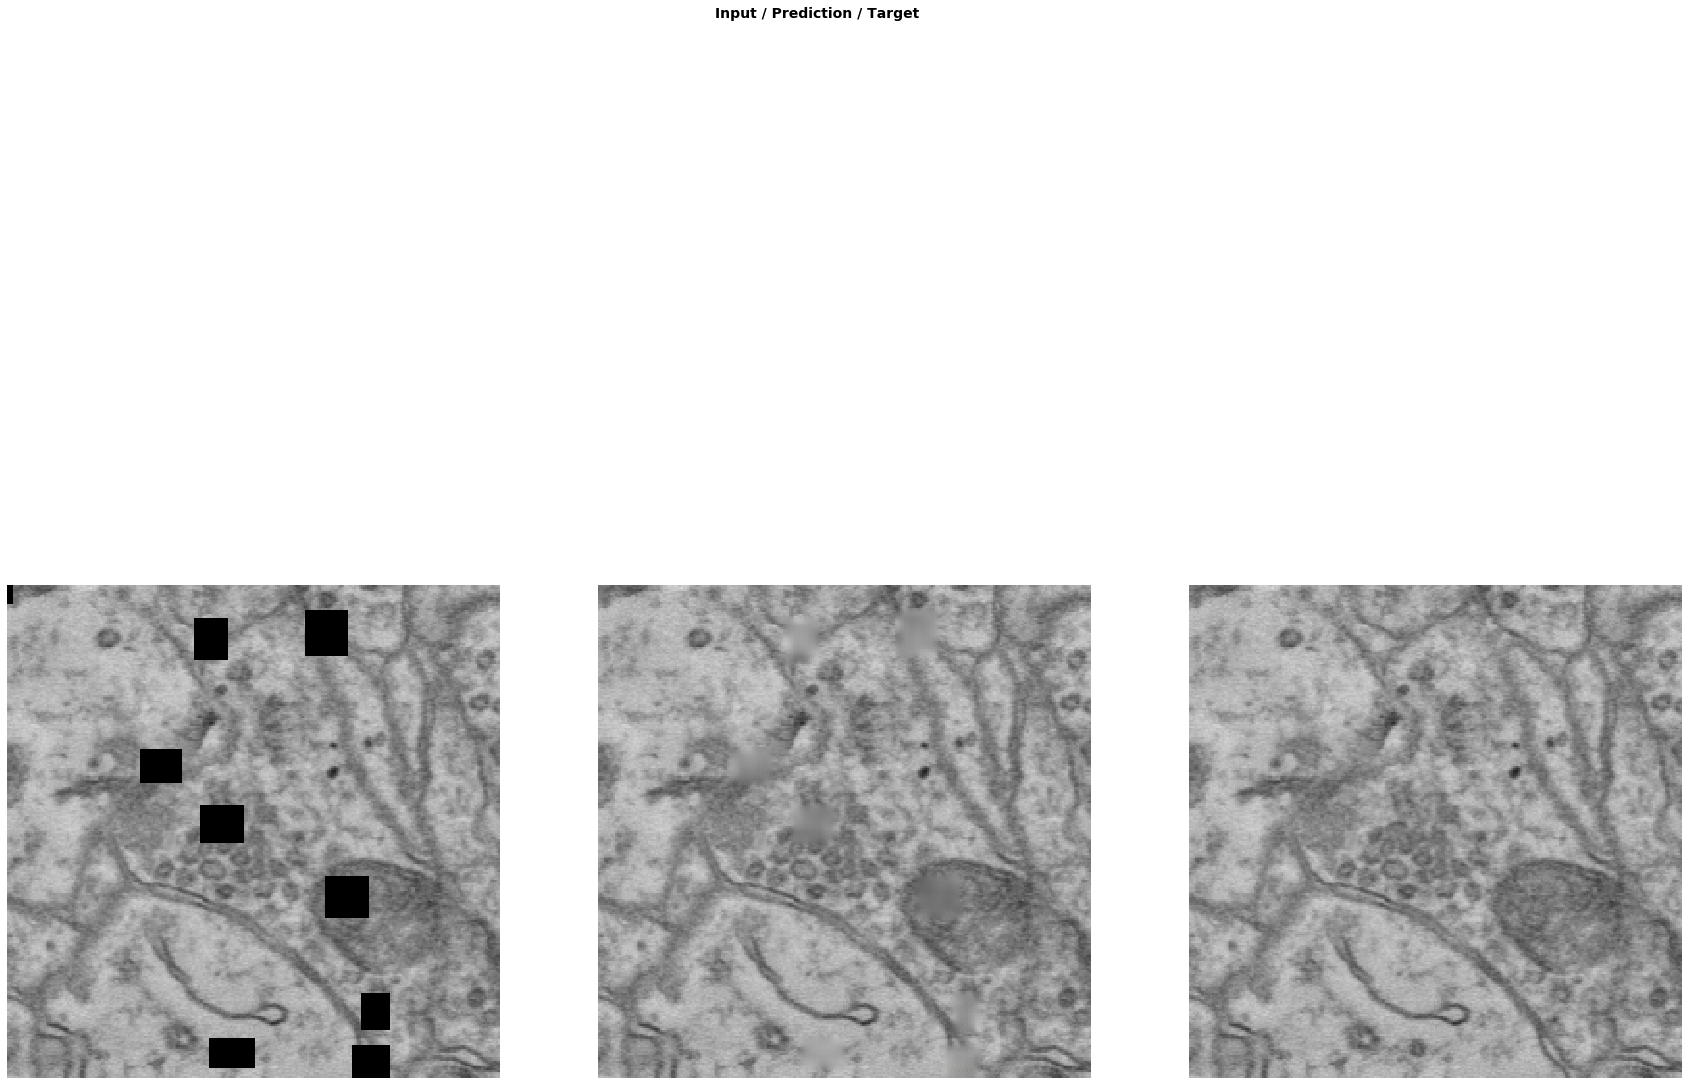

In [34]:
learn.show_results(rows=1, figsize=(30,24))

### 1b

In [35]:
learn.unfreeze()

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


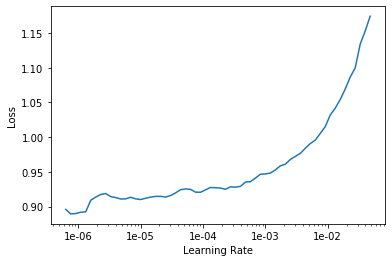

In [35]:
learn.recorder.plot()

In [37]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2b', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.007785,0.008329,0.008329,20.850565,0.952519,03:14
1,0.006391,0.006022,0.006022,22.288244,0.956909,03:19
2,0.005778,0.005529,0.005529,22.631865,0.960471,03:19


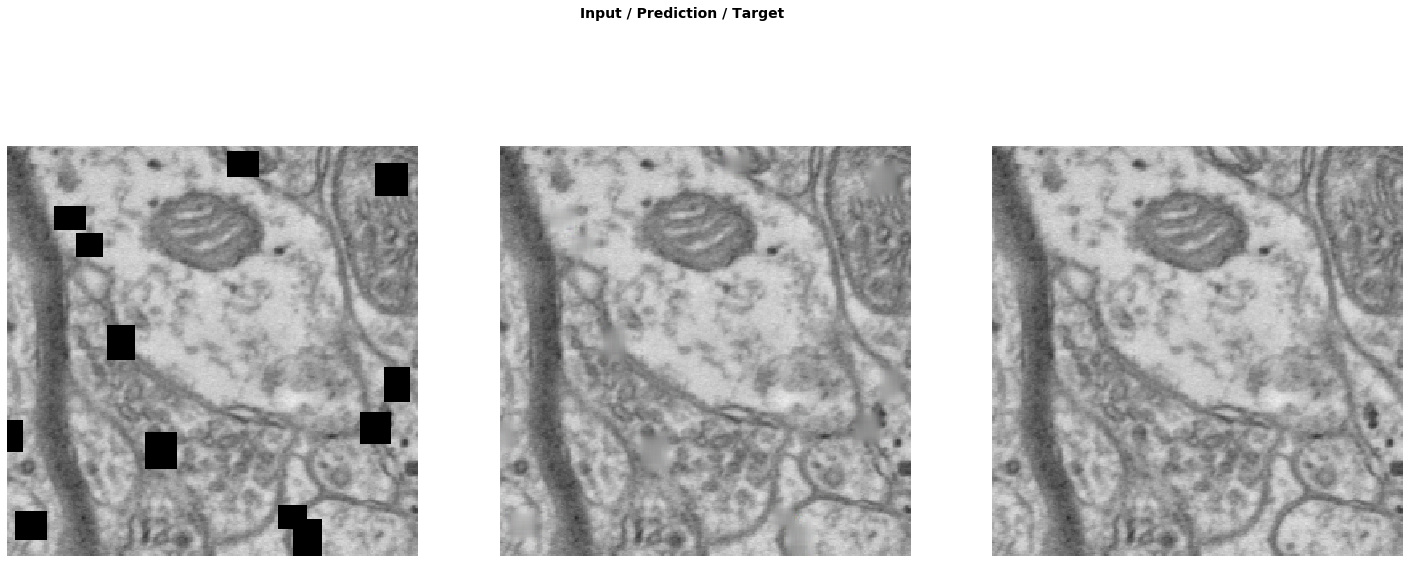

In [39]:
learn.show_results(rows=1, figsize=(25, 10))

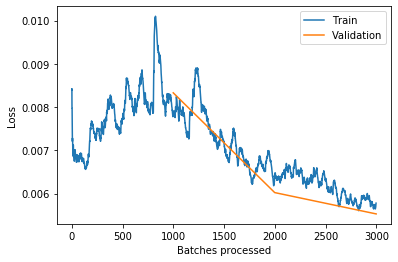

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.unfreeze()

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


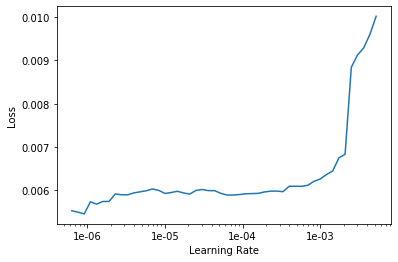

In [43]:
learn.recorder.plot()

In [44]:
lr = slice(3e-6, 3e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2c', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.005983,0.005560,0.005560,22.614983,0.960295,03:15
1,0.005715,0.005492,0.005492,22.666946,0.960802,03:19
2,0.005372,0.005309,0.005309,22.814064,0.961183,03:18


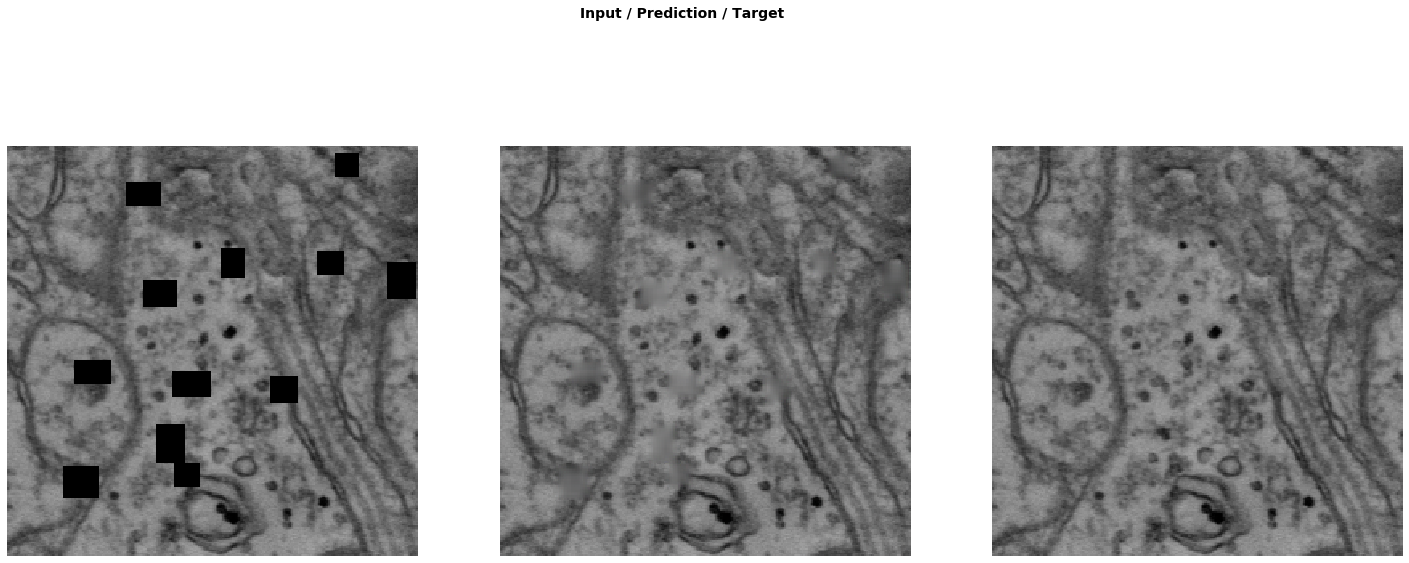

In [23]:
learn.show_results(rows=1, figsize=(25, 10))

## Change Loss Function to MAE

In [25]:
learn.loss_func = F.l1_loss

In [26]:
learn.loss_func

<function torch.nn.functional.l1_loss(input, target, size_average=None, reduce=None, reduction='mean')>

In [27]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


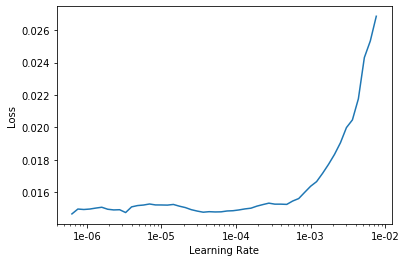

In [29]:
learn.recorder.plot()

In [30]:
lr = slice(3e-6, 3e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2d', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.017220,0.015985,0.005864,22.378059,0.960570,03:18
1,0.015231,0.014054,0.005122,22.962748,0.961990,03:19
2,0.014045,0.013479,0.005205,22.903917,0.962067,03:22


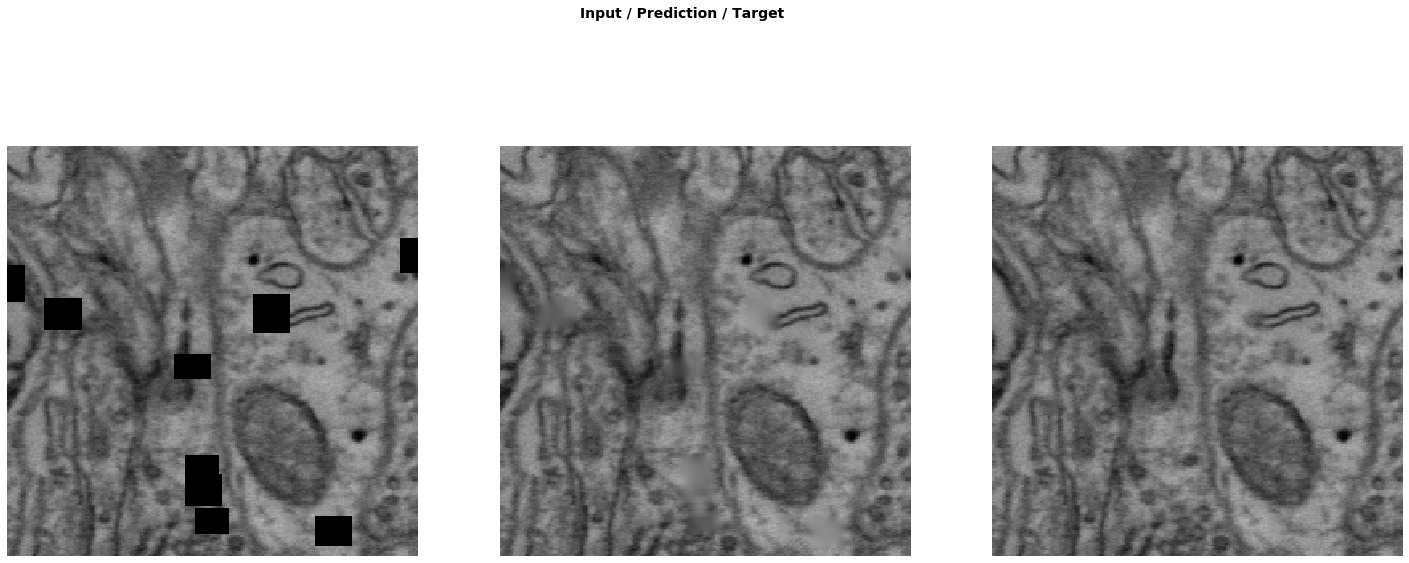

In [35]:
learn.show_results(rows=1, figsize=(25, 10))

In [36]:
lr = slice(3e-5, 3e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2e', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.029474,0.033593,0.007158,21.523382,0.957542,03:16
1,0.017162,0.014471,0.005321,22.798546,0.960786,03:20
2,0.013418,0.012890,0.005047,23.029247,0.962281,03:22


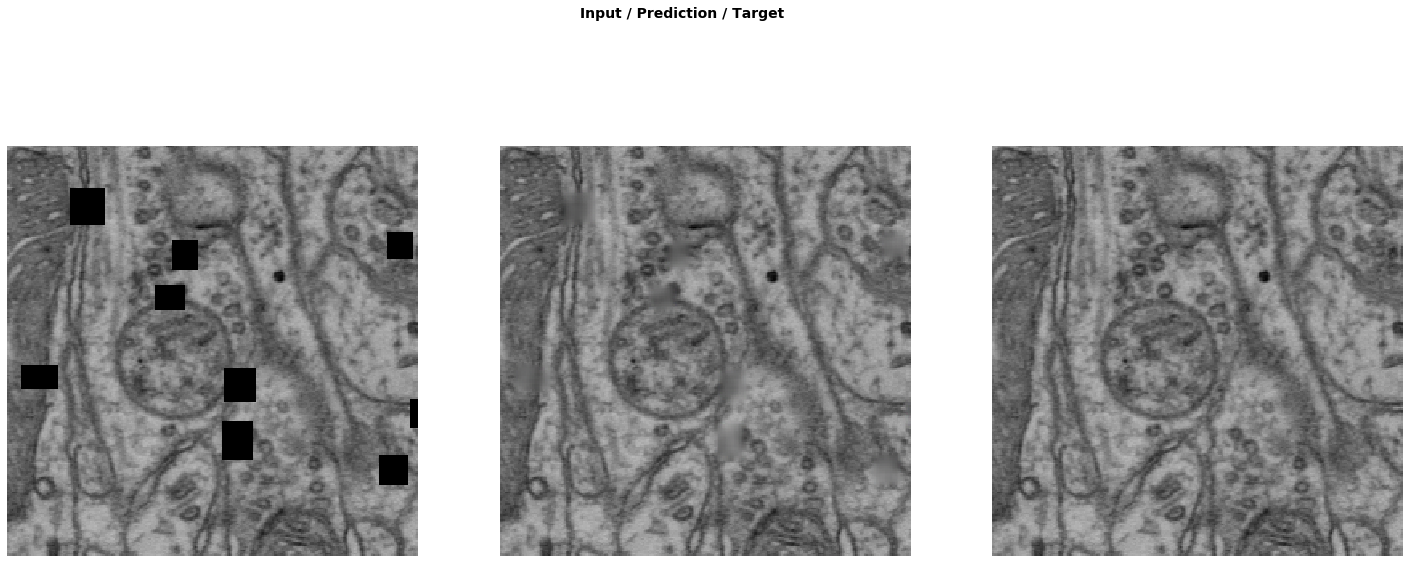

In [38]:
learn.show_results(rows=1, figsize=(25, 10))

In [39]:
lr = slice(3e-5, 3e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2f', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.018773,0.021000,0.005780,22.441835,0.958646,03:19
1,0.014436,0.014086,0.005228,22.869541,0.961220,03:23
2,0.012429,0.012127,0.004905,23.163488,0.962793,03:20


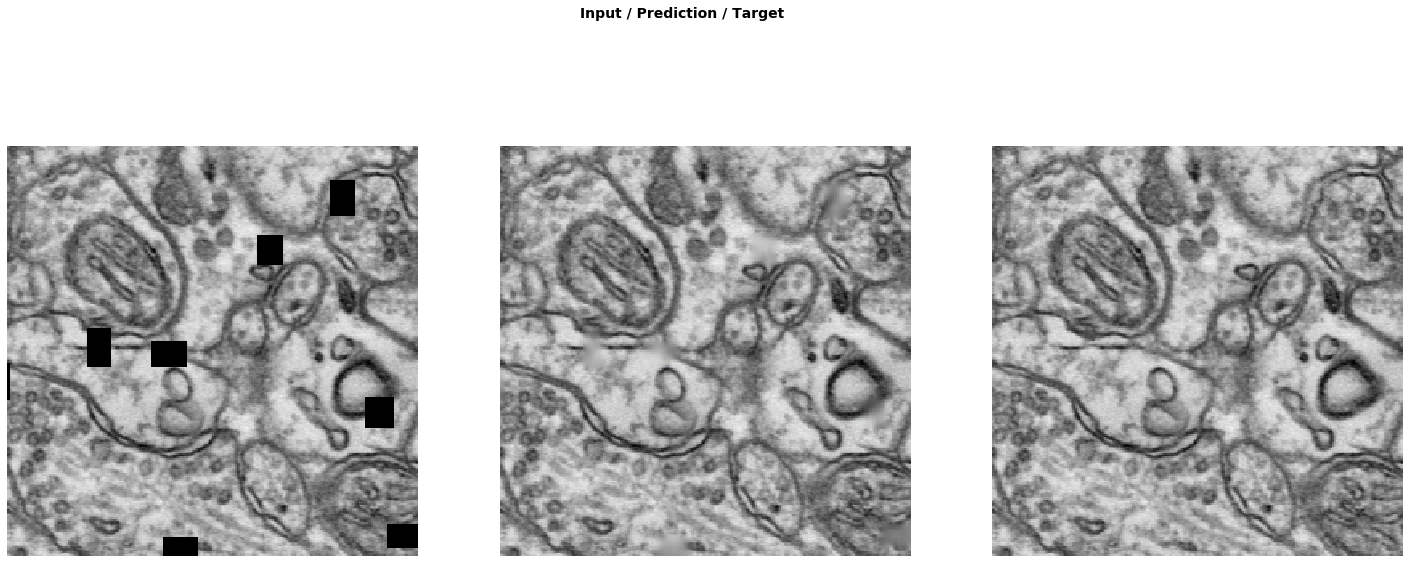

In [43]:
learn.show_results(rows=1, figsize=(25, 10))

In [46]:
learn.load(f"{nb_name}.2f");

In [47]:
learn.validate()

[0.012171686, tensor(0.0049), tensor(23.1331), tensor(0.9626)]

In [48]:
lr = 3e-4
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2g', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.012960,0.013130,0.005411,22.732889,0.961608,03:15
1,0.012680,0.012269,0.004890,23.162209,0.962718,03:20
2,0.012043,0.012205,0.005037,23.023607,0.962626,03:21


In [49]:
# Create databunch
data = get_patched_data(data_pth, hr_dir, bs, tfms=tfms,
                        in_sz=size, out_sz=size)
data = subsample(data)

In [50]:
learn.data = data

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


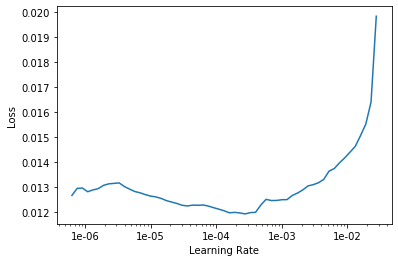

In [52]:
learn.recorder.plot()

In [53]:
lr = slice(3e-5, 3e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2g', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.012894,0.012350,0.005087,22.999058,0.962603,03:18
1,0.012632,0.012034,0.004894,23.174652,0.962996,03:20
2,0.012705,0.012046,0.004827,23.221384,0.962794,03:22


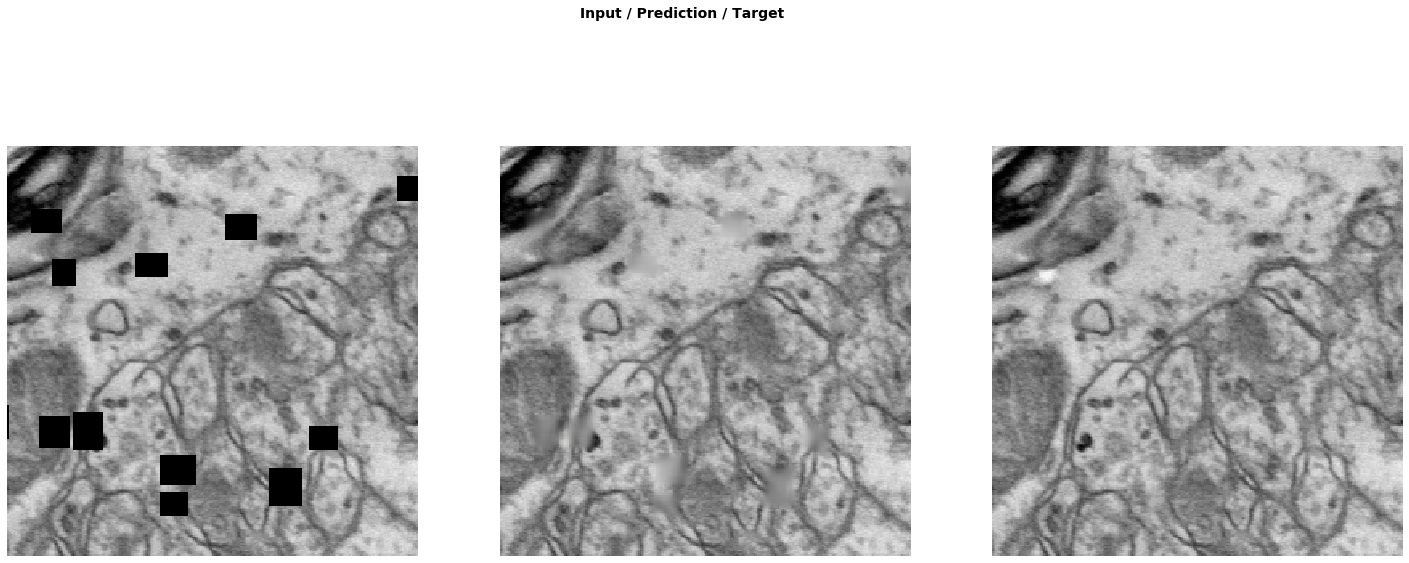

In [57]:
learn.show_results(rows=1, figsize=(25, 10))

In [64]:
learn.load(f'{nb_name}.2g');

In [65]:
learn.loss_func

<function torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='mean')>

In [66]:
learn.loss_func = F.mse_loss

In [67]:
learn.loss_func

<function torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='mean')>

In [68]:
lr = 1e-3
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2g', with_opt=False)

epoch,train_loss,valid_loss,mse_loss,psnr,ssim,time
0,0.007513,0.006041,0.006041,22.260235,0.957944,03:18
1,0.005584,0.004927,0.004927,23.144451,0.962574,03:19
2,0.005250,0.004758,0.004758,23.290270,0.962920,03:21


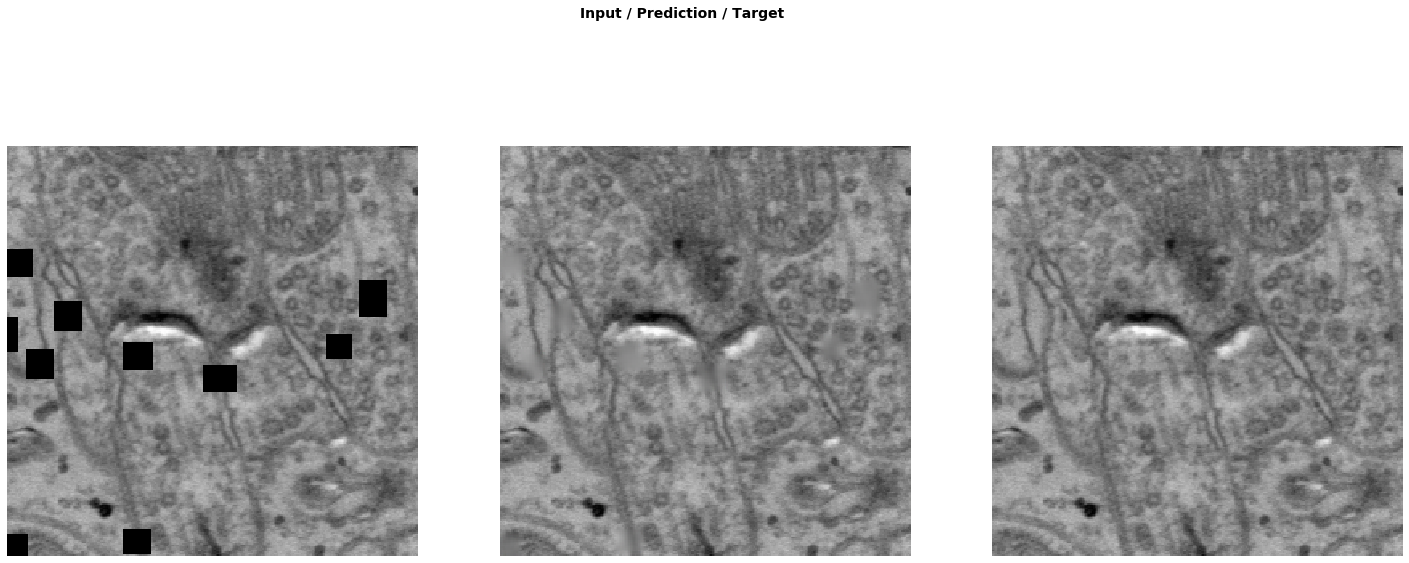

In [71]:
learn.show_results(rows=1, figsize=(25, 10))

# DEV

In [40]:
from fastai.vision import *
def get_patched_data(data_pth, hr_dir, bs, in_sz, out_sz,
                     tfms=None, num_workers=4, noise=None, max_zoom=1.1):
    src = get_patched_src(data_pth, hr_dir)
    
    data = (src
                .transform(tfms, size=in_sz, resize_method=ResizeMethod.CROP)
                .transform_y(None, size=out_sz, resize_method=ResizeMethod.CROP)
                .databunch(bs=bs, num_workers=num_workers)
                .normalize(imagenet_stats, do_y=True))
    data.c = 3
    data.train_ds.tfms_y = None
    return data


def get_patched_src(data_pth, hr_dir):
    hr_tifs = data_pth/f'{hr_dir}'

    def map_to_hr(x):
        return hr_tifs/x.relative_to(hr_tifs).with_suffix(".tif")

    src = (ImageImageList
            .from_folder(hr_tifs)
            .split_by_rand_pct()
            .label_from_func(map_to_hr))
    return src